### Setup Python Path Using Temporary Guess + Config PROJECT_ROOT

In [4]:
import sys
import os

# Temporary add to import config
project_root_guess = os.path.abspath(os.path.join(os.getcwd(), '..'))
temp_src_path = os.path.join(project_root_guess, 'src')
if temp_src_path not in sys.path:
    sys.path.append(temp_src_path)

# Import PROJECT_ROOT and other config values
from config import PROJECT_ROOT, FRAUD_DATA_FULL_PATH, IP_MAPPING_FULL_PATH

# Remove temp and add correct path
if temp_src_path in sys.path:
    sys.path.remove(temp_src_path)

correct_src_path = os.path.join(PROJECT_ROOT, 'src')
if correct_src_path not in sys.path:
    sys.path.append(correct_src_path)

print(f"Feature Engineering Notebook Ready")
print(f"Project Root: {PROJECT_ROOT}")

Feature Engineering Notebook Ready
Project Root: C:\Users\Administrator\Desktop\10Academy\Week 5&6\Week5-6-fraud-detection


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('seaborn-v0_8')
sns.set_palette('deep')

from data_preprocessing import FraudDataPreprocessor
from config import MIN_COUNTRY_TXNS_FOR_FRAUD_RATE

# Instantiate the preprocessor
prep = FraudDataPreprocessor()

print("FraudDataPreprocessor instantiated")


FraudDataPreprocessor instantiated


### Load and Clean Data

In [10]:
prep.load_data()
prep.clean_fraud_data()

print("Data loaded and cleaned")
prep.fraud_df.head()

Loading datasets using absolute paths...

✅ Fraud_Data loaded: (151112, 11)
✅ IP Mapping loaded: (138846, 3)
✅ Credit Card loaded: (284807, 31)

Cleaning Fraud_Data...

Missing values before cleaning:
user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
dtype: int64

Duplicate rows before cleaning: 0

Duplicate rows after cleaning: 0
Cleaning complete.

Data loaded and cleaned


,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,ip_address_int
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,NaN
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,NaN
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,NaN
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NaN
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,NaN


### Merge Geolocation

In [11]:
prep.merge_geolocation()

print("Geolocation merged")
print(f"Unique countries: {prep.fraud_df['country'].nunique()}")
prep.fraud_df[['ip_address', 'country']].head(10)

Merging geolocation data (IP → Country)...

Unique countries mapped: 1
Geolocation merge complete.

Geolocation merged
Unique countries: 1


,ip_address,country
0,7.327584e+08,Australia
1,3.503114e+08,Australia
2,2.621474e+09,Australia
3,3.840542e+09,Australia
4,4.155831e+08,Australia
5,2.809315e+09,Australia
6,3.987484e+09,Australia
7,1.692459e+09,Australia
8,3.719094e+09,Australia
9,3.416747e+08,Australia


### Feature Engineering - Run and Explore

In [13]:
prep.feature_engineering()

df = prep.fraud_df  # For easy access

print("Feature Engineering Complete!")
print("New features added:")
new_features = [
    'hour_of_day', 'day_of_week', 'time_since_signup_hours',
    'user_transaction_count', 'device_transaction_count'
]
print(new_features)

df[new_features].describe()

Feature Engineering...

New features created:
   - hour_of_day, day_of_week
   - time_since_signup_hours
   - user_transaction_count, device_transaction_count

Feature Engineering Complete!
New features added:
['hour_of_day', 'day_of_week', 'time_since_signup_hours', 'user_transaction_count', 'device_transaction_count']


,hour_of_day,day_of_week,time_since_signup_hours,user_transaction_count,device_transaction_count
count,151112.000000,151112.000000,151112.000000,151112.0,151112.000000
mean,11.521593,3.011819,1370.008125,1.0,1.684367
std,6.912474,2.006203,868.406422,0.0,2.616954
min,0.000000,0.000000,0.000278,1.0,1.000000
25%,6.000000,1.000000,607.431528,1.0,1.000000
50%,12.000000,3.000000,1368.429306,1.0,1.000000
75%,17.000000,5.000000,2123.479028,1.0,1.000000
max,23.000000,6.000000,2879.992222,1.0,20.000000


### Visualize Time-Based Features

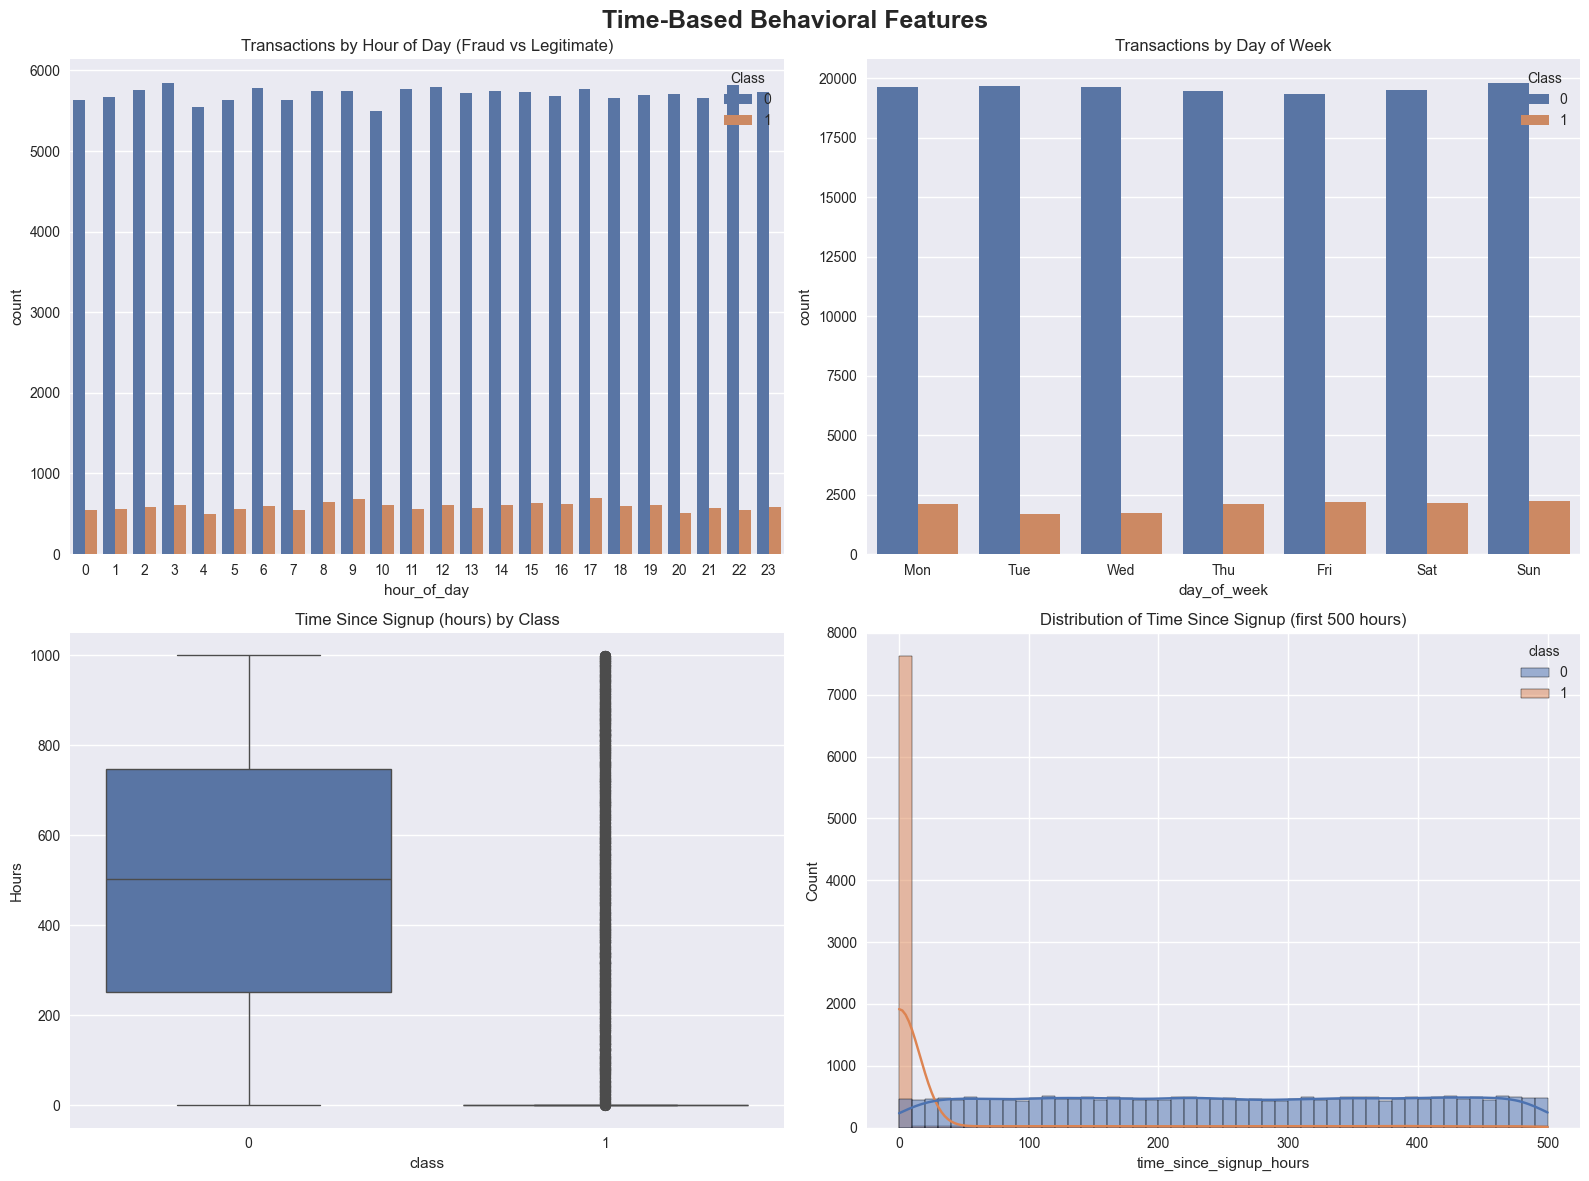

Insight: Fraud often occurs very quickly after signup — strong velocity signal


In [15]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Hour of Day Distribution by Class
sns.countplot(data=df, x='hour_of_day', hue='class', ax=axes[0,0])
axes[0,0].set_title('Transactions by Hour of Day (Fraud vs Legitimate)')
axes[0,0].legend(title='Class')

# Day of Week
day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
sns.countplot(data=df, x='day_of_week', hue='class', ax=axes[0,1])
axes[0,1].set_title('Transactions by Day of Week')
axes[0,1].set_xticklabels(day_names)
axes[0,1].legend(title='Class')

# Time Since Signup (capped for visibility)
sns.boxplot(data=df[df['time_since_signup_hours'] < 1000],
            x='class', y='time_since_signup_hours', ax=axes[1,0])
axes[1,0].set_title('Time Since Signup (hours) by Class')
axes[1,0].set_ylabel('Hours')

# Histogram of time since signup
sns.histplot(data=df[df['time_since_signup_hours'] < 500], x='time_since_signup_hours',
             hue='class', bins=50, kde=True, ax=axes[1,1])
axes[1,1].set_title('Distribution of Time Since Signup (first 500 hours)')

plt.suptitle('Time-Based Behavioral Features', fontsize=18, fontweight='bold')
plt.tight_layout()
plt.show()

print("Insight: Fraud often occurs very quickly after signup — strong velocity signal")

### Visualize Transaction Frequency Features

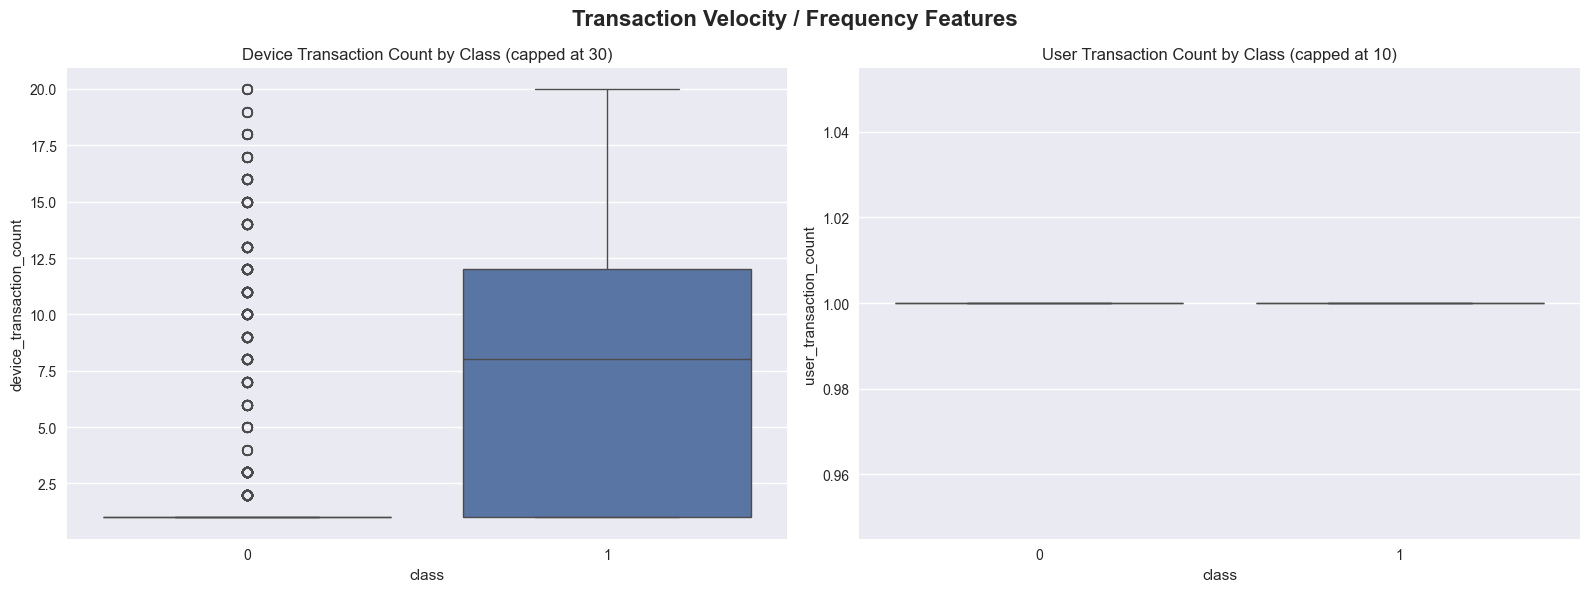

Insight: High device_transaction_count is a major fraud indicator (account takeover pattern)


In [16]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Device Transaction Count
sns.boxplot(data=df[df['device_transaction_count'] < 30],
            x='class', y='device_transaction_count', ax=axes[0])
axes[0].set_title('Device Transaction Count by Class (capped at 30)')

# User Transaction Count (mostly 1, but fraud may reuse)
sns.boxplot(data=df[df['user_transaction_count'] < 10],
            x='class', y='user_transaction_count', ax=axes[1])
axes[1].set_title('User Transaction Count by Class (capped at 10)')

plt.suptitle('Transaction Velocity / Frequency Features', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("Insight: High device_transaction_count is a major fraud indicator (account takeover pattern)")

### Country Fraud Risk (Re-run for confirmation)

Top 10 countries by fraud rate (min 50 transactions):

           fraud_rate   count
country                      
Australia      0.0936  151112



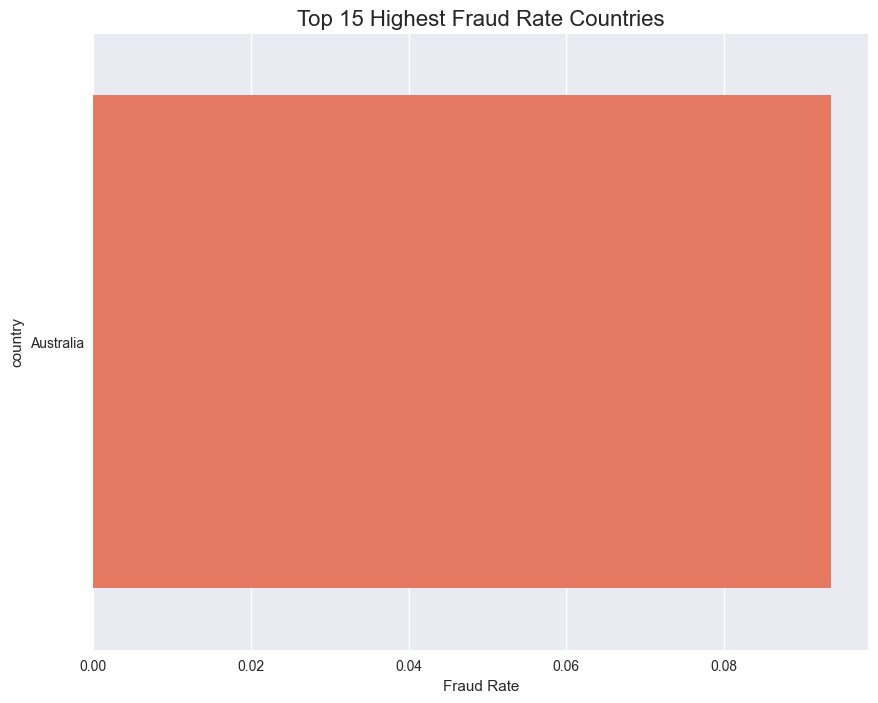

In [18]:
prep.analyze_fraud_by_country()

# Visualize top risky countries
country_stats = df.groupby('country')['class'].agg(['mean', 'count'])
country_stats = country_stats.rename(columns={'mean': 'fraud_rate'})
country_stats = country_stats[country_stats['count'] >= MIN_COUNTRY_TXNS_FOR_FRAUD_RATE]
top_15 = country_stats.sort_values('fraud_rate', ascending=False).head(15)

plt.figure(figsize=(10, 8))
sns.barplot(data=top_15.reset_index(), y='country', x='fraud_rate', palette='Reds_r')
plt.title('Top 15 Highest Fraud Rate Countries', fontsize=16)
plt.xlabel('Fraud Rate')
plt.show()

### Final Preprocessing and Save

In [19]:
prep.preprocess_for_modeling()

print("Feature engineering and preprocessing complete!")
print("Transformed features and target saved to data/processed/")
print("Ready for modeling!")

Preprocessing e-commerce features for modeling...

Transformed feature matrix shape: (151112, 14)
E-commerce features saved to: C:\Users\Administrator\Desktop\10Academy\Week 5&6\Week5-6-fraud-detection\data\processed\ecommerce_features.pkl
E-commerce target saved to: C:\Users\Administrator\Desktop\10Academy\Week 5&6\Week5-6-fraud-detection\data\processed\ecommerce_target.pkl

Feature engineering and preprocessing complete!
Transformed features and target saved to data/processed/
Ready for modeling!


### Summary

In [20]:
# Summary
print("FEATURE ENGINEERING SUMMARY\n")
print("Engineered Features:")
print("• Time-based: hour_of_day, day_of_week, time_since_signup_hours")
print("• Velocity: user_transaction_count, device_transaction_count")
print("• Geolocation: country (from IP range lookup)")
print("\nKey Fraud Signals Identified:")
print("1. Very short time between signup and purchase")
print("2. Multiple transactions from same device")
print("3. Transactions from high-risk countries")
print("4. Unusual hours or days")
print("\nAll features scaled and encoded — ready for model training!")

FEATURE ENGINEERING SUMMARY

Engineered Features:
• Time-based: hour_of_day, day_of_week, time_since_signup_hours
• Velocity: user_transaction_count, device_transaction_count
• Geolocation: country (from IP range lookup)

Key Fraud Signals Identified:
1. Very short time between signup and purchase
2. Multiple transactions from same device
3. Transactions from high-risk countries
4. Unusual hours or days

All features scaled and encoded — ready for model training!
